In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

In [13]:
user_df = pd.read_csv("users.csv")
game_df = pd.read_csv("games.csv")
recommendation_df = pd.read_csv("recommendations.csv")




,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [29]:

user_df.info()
game_df.info()
recommendation_df.info()
user_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          50872 non-null  int64         
 1   title           50872 non-null  object        
 2   date_release    50872 non-null  datetime64[ns]
 3   win             50872 non-null  bool          
 4   mac             50872 non-null  bool          
 5   linux           50872 non-null  bool          
 6   rating          50872 non-null  object        
 7   positive_ratio  50872 non-null  int64         
 8   user_reviews    50872 non-null  int64         
 9   price_final     50872 non-null  float64       
 10  pri

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [15]:
# Convert date_release to datetime
game_df['date_release'] = pd.to_datetime(game_df['date_release'])
recommendation_df['date'] = pd.to_datetime(recommendation_df['date'])

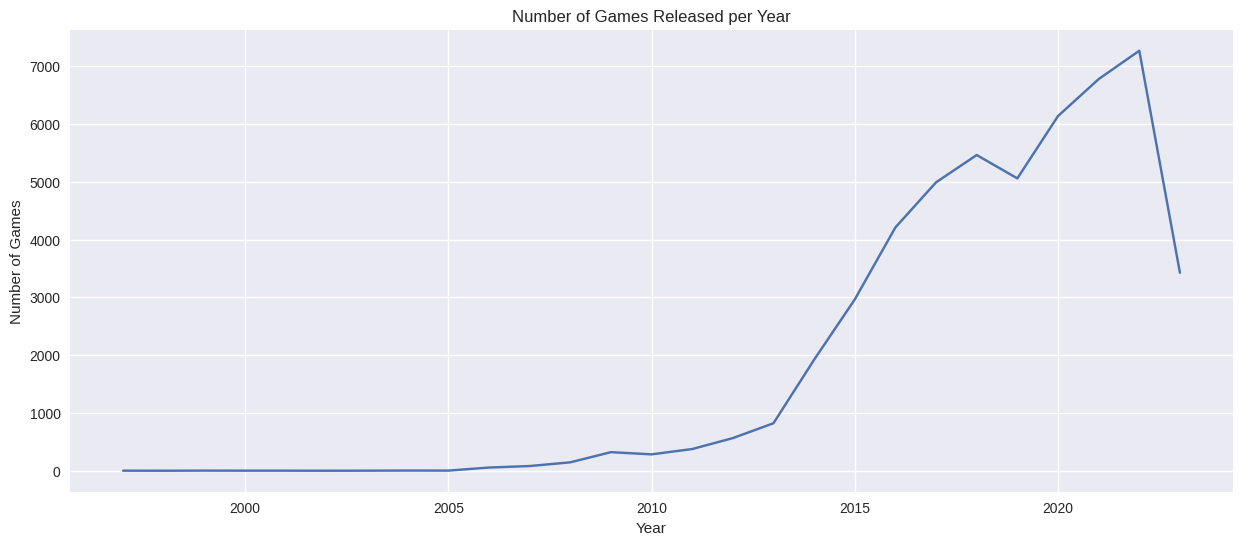

In [16]:
# 1. Game Release Trends
plt.figure(figsize=(15, 6))
game_df['date_release'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Number of Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()


<Figure size 1000x600 with 0 Axes>

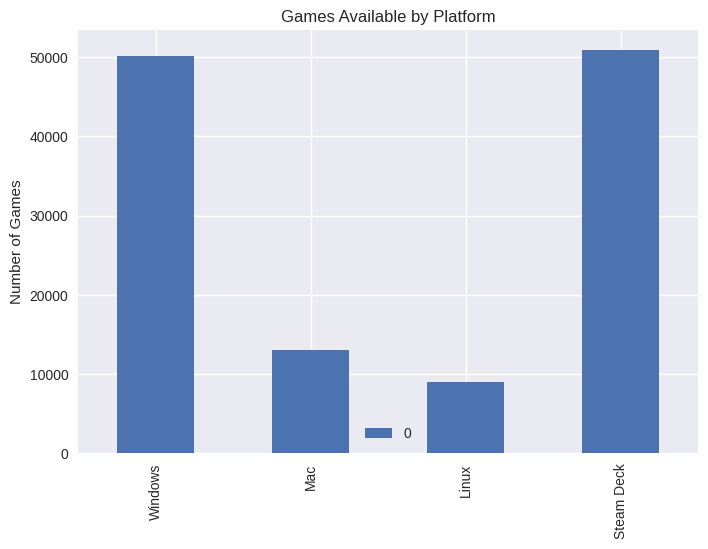

In [17]:
# 2. Platform Distribution
platforms = pd.DataFrame({
    'Windows': game_df['win'].sum(),
    'Mac': game_df['mac'].sum(),
    'Linux': game_df['linux'].sum(),
    'Steam Deck': game_df['steam_deck'].sum()
}, index=[0]).T
plt.figure(figsize=(10, 6))
platforms.plot(kind='bar')
plt.title('Games Available by Platform')
plt.ylabel('Number of Games')
plt.show()


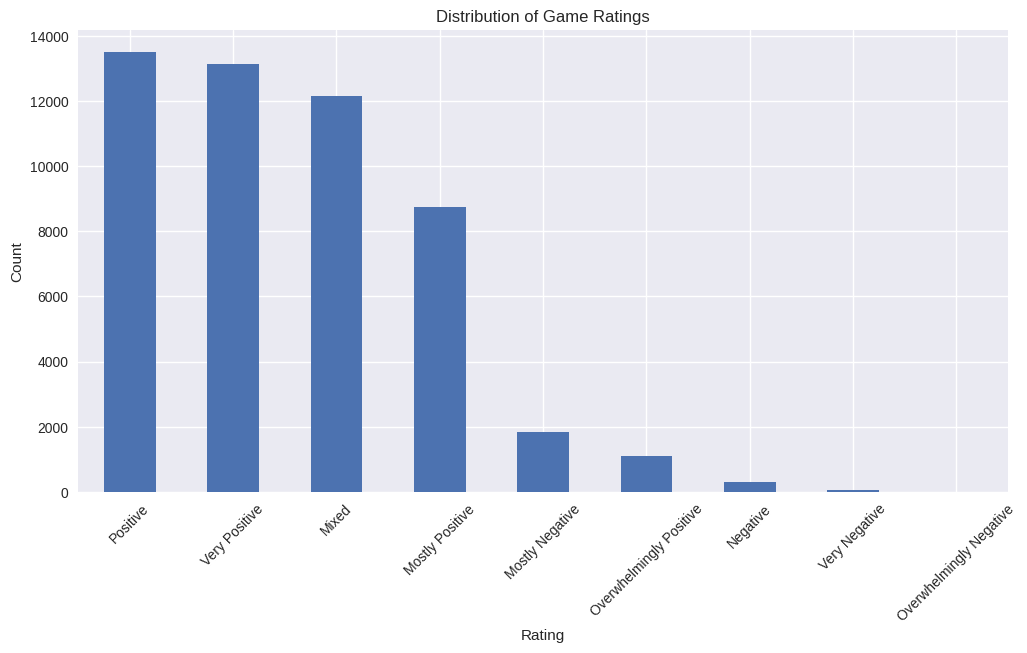

In [18]:
# 3. Rating Distribution
plt.figure(figsize=(12, 6))
game_df['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Game Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


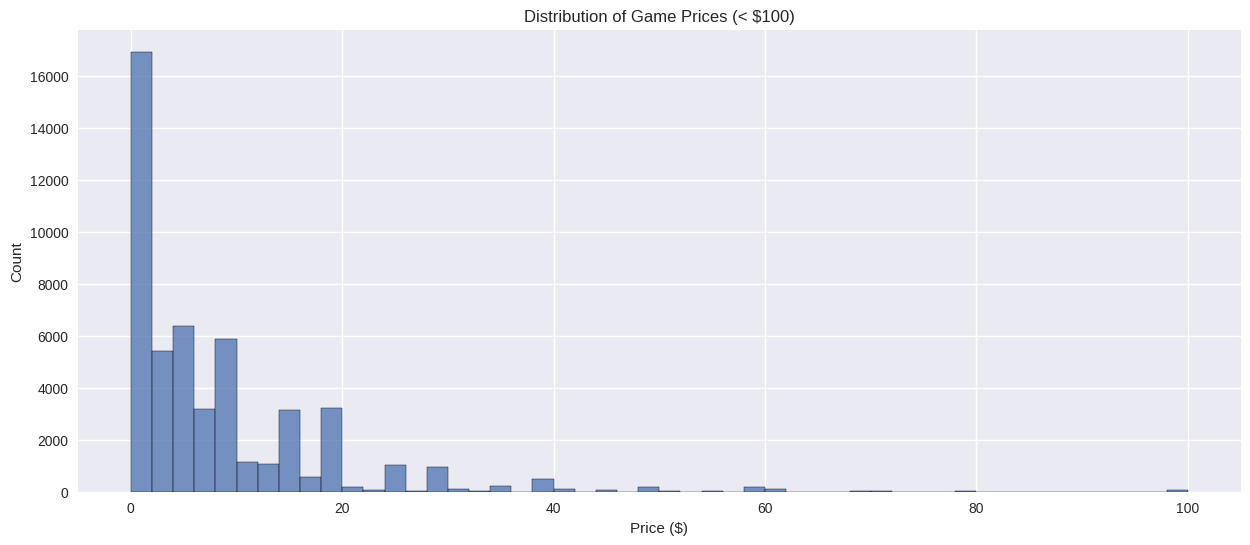

In [19]:
# 4. Price Analysis
plt.figure(figsize=(15, 6))
sns.histplot(data=game_df[game_df['price_final'] < 100], x='price_final', bins=50)
plt.title('Distribution of Game Prices (< $100)')
plt.xlabel('Price ($)')
plt.show()


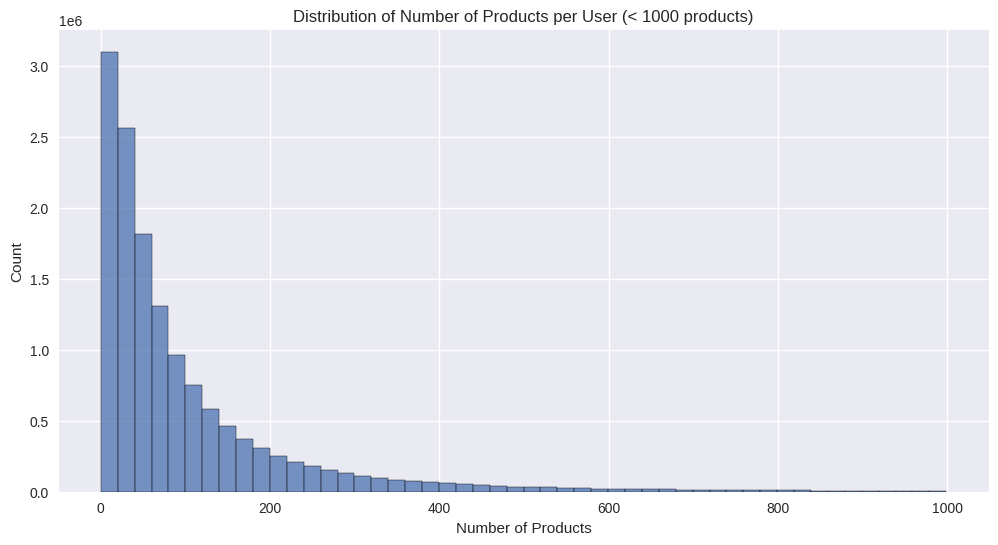

In [20]:
# 5. User Activity Analysis
plt.figure(figsize=(12, 6))
sns.histplot(data=user_df[user_df['products'] < 1000], x='products', bins=50)
plt.title('Distribution of Number of Products per User (< 1000 products)')
plt.xlabel('Number of Products')
plt.show()

In [21]:
def prepare_improved_recommendation_data(user_df, game_df, recommendation_df, sample_size=50000):
    """Prepare the recommendation data with better filtering"""
    print("Sampling and preparing data...")
    
    # Sample recommendations
    recommendation_sample = recommendation_df.sample(n=sample_size, random_state=42)
    print(f"Initial sample size: {len(recommendation_sample)}")
    
    # Convert to integer and add positive/negative weight
    recommendation_sample['is_recommended'] = recommendation_sample['is_recommended'].astype(int)
    
    # Filter users and games
    user_interactions = recommendation_sample['user_id'].value_counts()
    game_interactions = recommendation_sample['app_id'].value_counts()
    
    min_user_interactions = 2
    min_game_interactions = 2
    
    valid_users = user_interactions[user_interactions >= min_user_interactions].index
    valid_games = game_interactions[game_interactions >= min_game_interactions].index
    
    filtered_recommendations = recommendation_sample[
        (recommendation_sample['user_id'].isin(valid_users)) &
        (recommendation_sample['app_id'].isin(valid_games))
    ]
    
    print(f"Filtered recommendations: {len(filtered_recommendations)}")
    print(f"Unique users: {len(valid_users)}")
    print(f"Unique games: {len(valid_games)}")
    
    # Create interaction matrix
    print("Creating interaction matrix...")
    interactions = filtered_recommendations.pivot(
        index='user_id',
        columns='app_id',
        values='is_recommended'
    ).fillna(0)
    
    return interactions.astype(np.int8)

def display_recommendations(user_id, recommender, interactions):
    """Display recommendations with improved formatting and error handling"""
    try:
        user_idx = interactions.index.get_loc(user_id)
        recommendations = recommender.get_recommendations(user_idx)
        
        if not recommendations:
            return "No recommendations found for this user."
        
        df = pd.DataFrame(recommendations)
        df = df[['title', 'rating', 'price', 'positive_ratio', 'user_reviews', 'score']]
        df['positive_ratio'] = df['positive_ratio'].apply(lambda x: f"{x:.1%}")
        df['score'] = df['score'].apply(lambda x: f"{x:.3f}")
        df['price'] = df['price'].apply(lambda x: f"${x:.2f}")
        return df
    
    except KeyError:
        return "User not found in the sample dataset"
    except Exception as e:
        return f"Error generating recommendations: {str(e)}"

class ImprovedGameRecommender:
    def __init__(self, interactions_matrix, game_df):
        self.interactions_matrix = interactions_matrix
        self.game_df = game_df
        
        # Create game mappings based on the columns in interactions_matrix
        self.game_indices = dict(enumerate(range(interactions_matrix.shape[1])))
        self.app_id_to_index = {v: k for k, v in self.game_indices.items()}
        
        # Compute game popularity (normalized)
        self.game_popularity = np.array(interactions_matrix.sum(axis=0)).flatten()
        self.game_popularity = (self.game_popularity - self.game_popularity.min()) / (
            self.game_popularity.max() - self.game_popularity.min() + 1e-10)
        
        # Use user-user similarity instead of item-item
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)
        
        print(f"Recommender initialized with {interactions_matrix.shape[0]} users and {interactions_matrix.shape[1]} games")
    
    def get_recommendations(self, user_idx, n_recommendations=5):
        user_profile = self.interactions_matrix[user_idx]
        
        if isinstance(user_profile, np.ndarray):
            user_profile = csr_matrix(user_profile)
        
        # Find similar users
        distances, indices = self.model.kneighbors(
            user_profile,
            n_neighbors=min(50, self.interactions_matrix.shape[0])
        )
        
        # Get games the user hasn't interacted with
        user_games = set(user_profile.nonzero()[1])
        all_games = set(range(self.interactions_matrix.shape[1]))
        candidate_games = list(all_games - user_games)
        
        if not candidate_games:
            return []
        
        # Calculate scores for candidate games
        scores = np.zeros(len(candidate_games))
        similar_users = indices[0][1:]  # Exclude the user themselves
        similar_distances = distances[0][1:]
        
        for i, game_idx in enumerate(candidate_games):
            # Weight recommendations by similarity
            game_ratings = self.interactions_matrix[similar_users, game_idx].toarray().flatten()
            if game_ratings.sum() > 0:
                similarity_score = np.dot(1 - similar_distances, game_ratings)
                popularity_score = self.game_popularity[game_idx]
                scores[i] = (0.7 * similarity_score) + (0.3 * popularity_score)
            else:
                scores[i] = 0.3 * self.game_popularity[game_idx]
        
        # Get top recommendations
        if scores.max() == 0:
            # If no scores, recommend popular games
            scores = self.game_popularity[candidate_games]
            
        top_game_indices = np.array(candidate_games)[np.argsort(-scores)[:n_recommendations]]
        
        recommendations = []
        for game_idx in top_game_indices:
            game_info = game_df.iloc[game_idx]
            recommendations.append({
                'app_id': game_info['app_id'],
                'title': game_info['title'],
                'rating': game_info['rating'],
                'price': game_info['price_final'],
                'positive_ratio': game_info['positive_ratio'],
                'user_reviews': game_info['user_reviews'],
                'score': float(scores[list(candidate_games).index(game_idx)])
            })
        
        return recommendations

In [22]:
# Create interaction matrix
print("Preparing recommendation data...")
interactions = prepare_improved_recommendation_data(user_df, game_df, recommendation_df)
interactions_sparse = csr_matrix(interactions.values)

print("\nInitializing recommender...")
recommender = ImprovedGameRecommender(interactions_sparse, game_df)

# Test recommendations
print("\nTesting recommendations...")
sample_user_ids = list(interactions.index[:5])
for user_id in sample_user_ids:
    print(f"\nRecommendations for user {user_id}:")
    recommendations_df = display_recommendations(user_id, recommender, interactions)
    print(recommendations_df)

# Print system statistics
print("\nSystem Statistics:")
print(f"Number of users in sample: {interactions.shape[0]}")
print(f"Number of games in sample: {interactions.shape[1]}")
print(f"Matrix sparsity: {100 * (1 - interactions_sparse.nnz / (interactions.shape[0] * interactions.shape[1])):.2f}%")
print(f"Average interactions per user: {interactions_sparse.sum() / interactions.shape[0]:.2f}")

# Analyze recommendation diversity
def analyze_recommendations(recommender, interactions, n_users=100):
    print("\nAnalyzing recommendation diversity...")
    all_recommended_games = []
    unique_ratings = set()
    prices = []
    
    sample_users = np.random.choice(interactions.shape[0], min(n_users, interactions.shape[0]), replace=False)
    
    for user_idx in sample_users:
        recommendations = recommender.get_recommendations(user_idx)
        for rec in recommendations:
            all_recommended_games.append(rec['title'])
            unique_ratings.add(rec['rating'])
            prices.append(rec['price'])
    
    print(f"\nUnique games recommended: {len(set(all_recommended_games))}")
    print(f"Unique ratings in recommendations: {len(unique_ratings)}")
    print(f"Average recommended game price: ${np.mean(prices):.2f}")
    print(f"Price range: ${min(prices):.2f} - ${max(prices):.2f}")

# Run diversity analysis
analyze_recommendations(recommender, interactions)

Preparing recommendation data...
Sampling and preparing data...
Initial sample size: 50000
Filtered recommendations: 806
Unique users: 508
Unique games: 3511
Creating interaction matrix...

Initializing recommender...
Recommender initialized with 454 users and 643 games

Testing recommendations...

Recommendations for user 7744:
                                          title         rating   price  \
0      World of Tanks — Rugged Mountaineer Pack       Positive  $49.99   
1                                    Magitek VR       Positive  $14.99   
2  STCC The Game 2 – Expansion Pack for RACE 07       Positive   $3.99   
3                                     Macbat 64  Very Positive   $1.99   
4         Borderlands 3: Gold Weapon Skins Pack          Mixed   $4.99   

  positive_ratio  user_reviews  score  
0        8300.0%            37  0.500  
1        8700.0%            16  0.425  
2        9200.0%            13  0.300  
3        9100.0%           282  0.300  
4        5100.0%        

In [23]:
class HybridGameRecommender(ImprovedGameRecommender):
    def __init__(self, interactions_matrix, game_df):
        super().__init__(interactions_matrix, game_df)
        
        # Initialize scalers
        self.price_scaler = MinMaxScaler()
        self.review_scaler = MinMaxScaler()
        
        # Create content features
        self.content_features = self._create_content_features()
        print(f"Content features shape: {self.content_features.shape}")
        
    def _create_content_features(self):
        # Create game features matrix
        features = pd.DataFrame(index=self.game_df.index)
        
        # Price features (normalized)
        features['price'] = self.price_scaler.fit_transform(
            self.game_df[['price_final']].fillna(0)
        ).flatten()
        
        # Rating features
        features['positive_ratio'] = self.game_df['positive_ratio'].fillna(0) / 100
        features['user_reviews'] = self.review_scaler.fit_transform(
            np.log1p(self.game_df[['user_reviews']].fillna(0))
        ).flatten()
        
        # Platform features
        features['win'] = self.game_df['win'].fillna(False).astype(float)
        features['mac'] = self.game_df['mac'].fillna(False).astype(float)
        features['linux'] = self.game_df['linux'].fillna(False).astype(float)
        
        # Rating categories (one-hot encoding)
        rating_dummies = pd.get_dummies(
            self.game_df['rating'].fillna('Unknown'), 
            prefix='rating'
        )
        features = pd.concat([features, rating_dummies], axis=1)
        
        # Steam Deck compatibility
        features['steam_deck'] = self.game_df['steam_deck'].fillna(False).astype(float)
        
        # Discount feature
        features['has_discount'] = (self.game_df['discount'] > 0).fillna(False).astype(float)
        
        # Convert all features to float
        features = features.astype(float)
        
        print("Feature columns:", features.columns.tolist())
        return features
    
    def _calculate_content_similarity(self, game_idx, user_idx):
        try:
            # Get user's played games
            user_games = self.interactions_matrix[user_idx].nonzero()[1]
            if len(user_games) == 0:
                return 0
            
            # Calculate average features of user's played games
            user_profile = self.content_features.iloc[user_games].mean().values
            game_profile = self.content_features.iloc[game_idx].values
            
            # Convert to numpy arrays and ensure they're float
            user_profile = np.array(user_profile, dtype=float)
            game_profile = np.array(game_profile, dtype=float)
            
            # Check for NaN values
            if np.any(np.isnan(user_profile)) or np.any(np.isnan(game_profile)):
                print(f"Warning: NaN values found for game_idx {game_idx}")
                return 0
            
            # Calculate cosine similarity
            if np.all(user_profile == 0) or np.all(game_profile == 0):
                return 0
                
            similarity = 1 - spatial.distance.cosine(user_profile, game_profile)
            return max(0, similarity)  # Ensure non-negative similarity
            
        except Exception as e:
            print(f"Error in _calculate_content_similarity for game_idx {game_idx}: {str(e)}")
            return 0
    
    def get_recommendations(self, user_idx, n_recommendations=5):
        try:
            # Get collaborative filtering recommendations
            cf_recommendations = super().get_recommendations(user_idx, n_recommendations * 2)
            
            if not cf_recommendations:
                return []
            
            # Calculate content similarity for recommended games
            for rec in cf_recommendations:
                game_idx = self.game_df[self.game_df['app_id'] == rec['app_id']].index[0]
                content_score = self._calculate_content_similarity(game_idx, user_idx)
                
                # Combine scores with weights
                cf_score = rec['score']
                popularity_score = min(1.0, rec['user_reviews'] / 1000)  # Cap at 1000 reviews
                
                # Final score combination
                rec['hybrid_score'] = {
                    'cf_score': cf_score,
                    'content_score': content_score,
                    'popularity_score': popularity_score
                }
                
                rec['score'] = (0.6 * cf_score + 
                              0.3 * content_score + 
                              0.1 * popularity_score)
            
            # Sort by combined score and return top N
            sorted_recs = sorted(cf_recommendations, key=lambda x: x['score'], reverse=True)
            
            # Add diversity
            diverse_recs = self._diversify_recommendations(sorted_recs, n_recommendations)
            
            return diverse_recs
            
        except Exception as e:
            print(f"Error in get_recommendations: {str(e)}")
            return []

    def _diversify_recommendations(self, recommendations, n):
        if len(recommendations) <= n:
            return recommendations
        
        diverse_recs = []
        price_ranges = set()
        ratings = set()
        
        for rec in recommendations:
            price = rec['price']
            rating = rec['rating']
            
            # Define price range
            if price < 5:
                price_range = 'budget'
            elif price < 15:
                price_range = 'mid'
            else:
                price_range = 'premium'
            
            # Add recommendation if it increases diversity
            if len(diverse_recs) < n and (
                len(diverse_recs) < n/2 or  # First half: best scores
                (price_range not in price_ranges or rating not in ratings)  # Second half: diversity
            ):
                diverse_recs.append(rec)
                price_ranges.add(price_range)
                ratings.add(rating)
                
            if len(diverse_recs) == n:
                break
                
        return diverse_recs

# Helper function to display more detailed recommendations
def display_detailed_recommendations(user_id, recommender, interactions):
    try:
        user_idx = interactions.index.get_loc(user_id)
        recommendations = recommender.get_recommendations(user_idx)
        
        if not recommendations:
            return "No recommendations found for this user."
        
        df = pd.DataFrame(recommendations)
        
        # Format columns
        if 'hybrid_score' in df.columns:
            df['cf_score'] = df['hybrid_score'].apply(lambda x: f"{x['cf_score']:.3f}")
            df['content_score'] = df['hybrid_score'].apply(lambda x: f"{x['content_score']:.3f}")
            df['popularity_score'] = df['hybrid_score'].apply(lambda x: f"{x['popularity_score']:.3f}")
            df = df.drop('hybrid_score', axis=1)
            
        df['positive_ratio'] = df['positive_ratio'].apply(lambda x: f"{x:.1%}")
        df['score'] = df['score'].apply(lambda x: f"{x:.3f}")
        df['price'] = df['price'].apply(lambda x: f"${x:.2f}")
        
        # Reorder columns
        columns = ['title', 'rating', 'price', 'positive_ratio', 'user_reviews', 'score']
        if 'cf_score' in df.columns:
            columns.extend(['cf_score', 'content_score', 'popularity_score'])
            
        return df[columns]
    
    except KeyError:
        return "User not found in the sample dataset"
    except Exception as e:
        return f"Error generating recommendations: {str(e)}"

# Initialize hybrid recommender
print("Initializing hybrid recommender...")
hybrid_recommender = HybridGameRecommender(interactions_sparse, game_df)

# Compare recommendations
print("\nComparing recommendations between models...")
sample_user = interactions.index[0]
print(f"\nOriginal Recommendations for user {sample_user}:")
print(display_recommendations(sample_user, recommender, interactions))
print(f"\nHybrid Recommendations for user {sample_user}:")
print(display_detailed_recommendations(sample_user, hybrid_recommender, interactions))

# Analyze diversity
def analyze_hybrid_diversity(recommender, hybrid_recommender, interactions, n_samples=50):
    original_diversity = {
        'unique_games': set(),
        'price_ranges': set(),
        'ratings': set()
    }
    
    hybrid_diversity = {
        'unique_games': set(),
        'price_ranges': set(),
        'ratings': set()
    }
    
    sample_users = np.random.choice(interactions.shape[0], min(n_samples, interactions.shape[0]), replace=False)
    
    for user_idx in sample_users:
        # Original recommendations
        orig_recs = recommender.get_recommendations(user_idx)
        for rec in orig_recs:
            original_diversity['unique_games'].add(rec['title'])
            original_diversity['ratings'].add(rec['rating'])
            original_diversity['price_ranges'].add(
                'budget' if rec['price'] < 5 else 'mid' if rec['price'] < 15 else 'premium'
            )
        
        # Hybrid recommendations
        hybrid_recs = hybrid_recommender.get_recommendations(user_idx)
        for rec in hybrid_recs:
            hybrid_diversity['unique_games'].add(rec['title'])
            hybrid_diversity['ratings'].add(rec['rating'])
            hybrid_diversity['price_ranges'].add(
                'budget' if rec['price'] < 5 else 'mid' if rec['price'] < 15 else 'premium'
            )
    
    print("\nDiversity Analysis:")
    print("\nOriginal Recommender:")
    print(f"Unique games: {len(original_diversity['unique_games'])}")
    print(f"Unique ratings: {len(original_diversity['ratings'])}")
    print(f"Price ranges covered: {len(original_diversity['price_ranges'])}")
    
    print("\nHybrid Recommender:")
    print(f"Unique games: {len(hybrid_diversity['unique_games'])}")
    print(f"Unique ratings: {len(hybrid_diversity['ratings'])}")
    print(f"Price ranges covered: {len(hybrid_diversity['price_ranges'])}")
    
# Run diversity analysis
print("\nAnalyzing recommendation diversity...")
analyze_hybrid_diversity(recommender, hybrid_recommender, interactions)

Initializing hybrid recommender...
Recommender initialized with 454 users and 643 games
Feature columns: ['price', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'rating_Mixed', 'rating_Mostly Negative', 'rating_Mostly Positive', 'rating_Negative', 'rating_Overwhelmingly Negative', 'rating_Overwhelmingly Positive', 'rating_Positive', 'rating_Very Negative', 'rating_Very Positive', 'steam_deck', 'has_discount']
Content features shape: (50872, 17)

Comparing recommendations between models...

Original Recommendations for user 7744:
                                          title         rating   price  \
0      World of Tanks — Rugged Mountaineer Pack       Positive  $49.99   
1                                    Magitek VR       Positive  $14.99   
2  STCC The Game 2 – Expansion Pack for RACE 07       Positive   $3.99   
3                                     Macbat 64  Very Positive   $1.99   
4         Borderlands 3: Gold Weapon Skins Pack          Mixed   $4.99   

  positiv

In [24]:
# Sort users by the number of reviews in descending order
sorted_users = user_df.sort_values(by='reviews', ascending=False)

# Display the top 10 users with the most reviews
print(sorted_users.head(10))


           user_id  products  reviews
4803549   11764552      7898     6045
9965497    5112758      1226     4152
13741354  11656130      1807     3840
12041089   5669734      4737     3479
8734053   11553593      1919     3392
4961584    5390510       721     3023
14020593   4457971      2043     2720
4026020    4318160      3702     2714
13663115    574944      5920     2626
5512863    1365585      2090     2470


In [30]:
def get_user_data(user_id, user_df, recommendation_df, game_df):
    """
    Fetch user-specific data for the /user page.
    
    Parameters:
        user_id (int): The ID of the user.
        user_df (pd.DataFrame): DataFrame containing user information.
        recommendation_df (pd.DataFrame): DataFrame with user-game interactions.
        game_df (pd.DataFrame): DataFrame with game information.
    
    Returns:
        dict: User data including info, reviews, and games.
    """
    # Fetch user information
    user_info = user_df[user_df['user_id'] == user_id].to_dict(orient='records')
    if not user_info:
        return {"error": f"User with ID {user_id} not found."}

    user_info = user_info[0]  # Extract the single user's info

    # Fetch reviews and interactions
    user_reviews = recommendation_df[recommendation_df['user_id'] == user_id]
    
    # Join with game_df to include game details
    user_reviews = user_reviews.merge(
        game_df, 
        how='left', 
        left_on='app_id', 
        right_on='app_id'
    )
    
    # Format reviews into a list of dictionaries
    reviews_list = user_reviews[[
        'app_id', 'title', 'is_recommended', 'hours', 'helpful', 'funny'
    ]].to_dict(orient='records')

    # Construct the final output
    return {
        "user_info": {
            "user_id": user_info['user_id'],
            "total_reviews": user_info['reviews'],
            "total_products_interacted": user_info['products'],
        },
        "reviews": reviews_list
    }


In [31]:
game_df.head()


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [33]:
user_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [32]:
recommendation_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [36]:
get_user_data(11764552, user_df, recommendation_df, game_df)

{'user_info': {'user_id': 11764552,
  'total_reviews': 6045,
  'total_products_interacted': 7898},
 'reviews': [{'app_id': 1286830,
   'title': 'STAR WARS™: The Old Republic™',
   'is_recommended': True,
   'hours': 5.9,
   'helpful': 0,
   'funny': 0},
  {'app_id': 440900,
   'title': 'Conan Exiles',
   'is_recommended': True,
   'hours': 41.6,
   'helpful': 0,
   'funny': 2},
  {'app_id': 306130,
   'title': 'The Elder Scrolls® Online',
   'is_recommended': True,
   'hours': 34.3,
   'helpful': 2,
   'funny': 0},
  {'app_id': 1599340,
   'title': 'Lost Ark',
   'is_recommended': True,
   'hours': 65.0,
   'helpful': 0,
   'funny': 0},
  {'app_id': 252490,
   'title': 'Rust',
   'is_recommended': False,
   'hours': 18.5,
   'helpful': 4,
   'funny': 0},
  {'app_id': 244210,
   'title': 'Assetto Corsa',
   'is_recommended': False,
   'hours': 0.5,
   'helpful': 0,
   'funny': 4},
  {'app_id': 244850,
   'title': 'Space Engineers',
   'is_recommended': False,
   'hours': 6.0,
   'helpfu

In [60]:
def get_game_data(app_id, game_df, recommendation_df, user_df):
    """
    Fetch game-specific data for the /game page.
    
    Parameters:
        app_id (int): The ID of the game.
        game_df (pd.DataFrame): DataFrame containing game information.
        recommendation_df (pd.DataFrame): DataFrame with user-game interactions.
        user_df (pd.DataFrame): DataFrame with user information.
    
    Returns:
        dict: Game data including metadata, user interactions, and statistics.
    """
    # Fetch game metadata
    game_info = game_df[game_df['app_id'] == app_id].to_dict(orient='records')
    if not game_info:
        return {"error": f"Game with ID {app_id} not found."}
    
    game_info = game_info[0]  # Extract the single record as a dictionary

    # Fetch all interactions related to this game
    game_interactions = recommendation_df[recommendation_df['app_id'] == app_id]

    # Compute aggregated statistics
    total_reviews = len(game_interactions)
    recommended_count = game_interactions['is_recommended'].sum()
    recommendation_rate = recommended_count / total_reviews if total_reviews > 0 else 0
    avg_hours_played = game_interactions['hours'].mean() if total_reviews > 0 else 0

    # Fetch user reviews for the game
    user_reviews = game_interactions.merge(user_df, on='user_id', how='left')
    user_reviews = user_reviews[['user_id', 'hours', 'is_recommended', 'helpful', 'funny']]

    # Prepare the response
    game_data = {
        "game_info": game_info,
        "statistics": {
            "total_reviews": total_reviews,
            "recommended_count": recommended_count,
            "recommendation_rate": round(recommendation_rate, 2),
            "avg_hours_played": round(avg_hours_played, 2),
        },
        "user_reviews": user_reviews.to_dict(orient='records'),
    }
    
    return game_data

get_game_data(7000, game_df, recommendation_df, user_df)

{'game_info': {'app_id': 7000,
  'title': 'Tomb Raider: Legend',
  'date_release': Timestamp('2007-03-29 00:00:00'),
  'win': True,
  'mac': False,
  'linux': False,
  'rating': 'Very Positive',
  'positive_ratio': 88,
  'user_reviews': 3728,
  'price_final': 6.99,
  'price_original': 6.99,
  'discount': 0.0,
  'steam_deck': True},
 'statistics': {'total_reviews': 3000,
  'recommended_count': 2644,
  'recommendation_rate': 0.88,
  'avg_hours_played': 14.83},
 'user_reviews': [{'user_id': 11242339,
   'hours': 7.2,
   'is_recommended': True,
   'helpful': 3,
   'funny': 0},
  {'user_id': 6171331,
   'hours': 4.2,
   'is_recommended': False,
   'helpful': 0,
   'funny': 0},
  {'user_id': 4599320,
   'hours': 11.4,
   'is_recommended': False,
   'helpful': 0,
   'funny': 0},
  {'user_id': 12867388,
   'hours': 7.8,
   'is_recommended': True,
   'helpful': 0,
   'funny': 0},
  {'user_id': 978283,
   'hours': 11.9,
   'is_recommended': True,
   'helpful': 0,
   'funny': 0},
  {'user_id': 11

In [40]:
import matplotlib.pyplot as plt

# 1. User's Review Distribution by Rating
def plot_user_rating_distribution(recommendation_df, user_id):
    user_reviews = recommendation_df[recommendation_df['user_id'] == user_id]
    ratings = user_reviews['is_recommended'].value_counts()

    plt.figure(figsize=(8, 5))
    ratings.plot(kind='bar', color=['green', 'red'], alpha=0.7)
    plt.title(f"Rating Distribution for User {user_id}")
    plt.xlabel("Recommendation (1 = Recommended, 0 = Not Recommended)")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# 2. User's Playtime Distribution
def plot_user_playtime_distribution(recommendation_df, user_id):
    user_reviews = recommendation_df[recommendation_df['user_id'] == user_id]

    plt.figure(figsize=(8, 5))
    plt.hist(user_reviews['hours'], bins=10, color='blue', alpha=0.7)
    plt.title(f"Playtime Distribution for User {user_id}")
    plt.xlabel("Hours Played")
    plt.ylabel("Count")
    plt.show()

# 3. User's Review Activity Over Time
def plot_user_reviews_over_time(recommendation_df, user_id):
    user_reviews = recommendation_df[recommendation_df['user_id'] == user_id]
    user_reviews['date'] = pd.to_datetime(user_reviews['date'])
    reviews_by_date = user_reviews.groupby(user_reviews['date'].dt.date).size()

    plt.figure(figsize=(10, 6))
    reviews_by_date.plot(kind='line', marker='o')
    plt.title(f"Review Activity Over Time for User {user_id}")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.grid(True)
    plt.show()

# 4. Comparison of User's Average Playtime vs. Global Average
def plot_user_vs_global_playtime(recommendation_df, user_id):
    global_avg = recommendation_df['hours'].mean()
    user_avg = recommendation_df[recommendation_df['user_id'] == user_id]['hours'].mean()

    plt.figure(figsize=(6, 4))
    plt.bar(['Global Average', f'User {user_id}'], [global_avg, user_avg], color=['gray', 'blue'])
    plt.title("Average Playtime Comparison")
    plt.ylabel("Average Hours Played")
    plt.show()


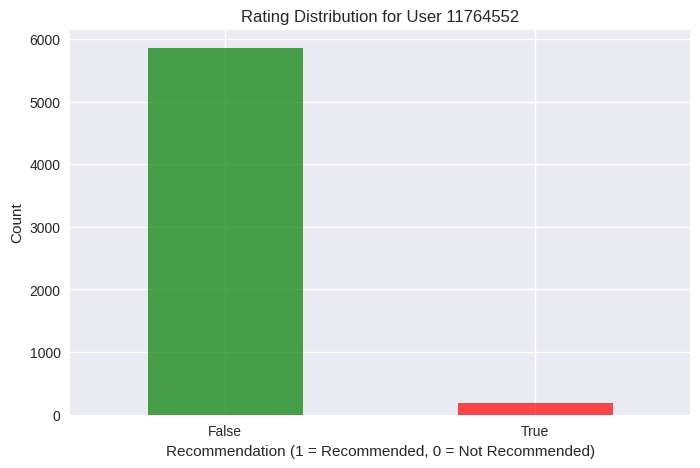

In [42]:
plot_user_rating_distribution(recommendation_df, 11764552)

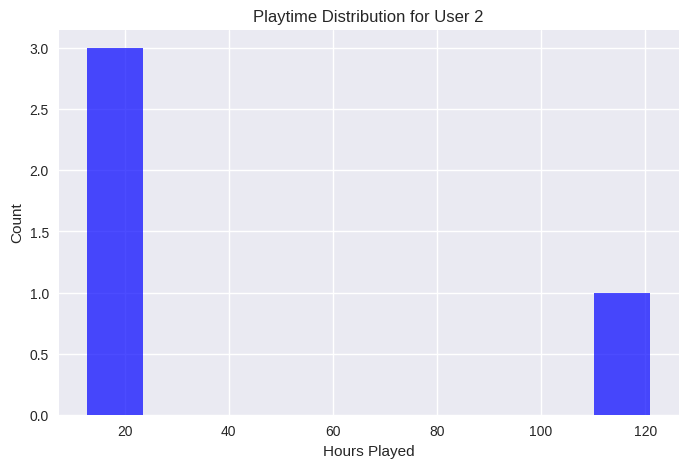

In [47]:
plot_user_playtime_distribution(recommendation_df, 11764552)

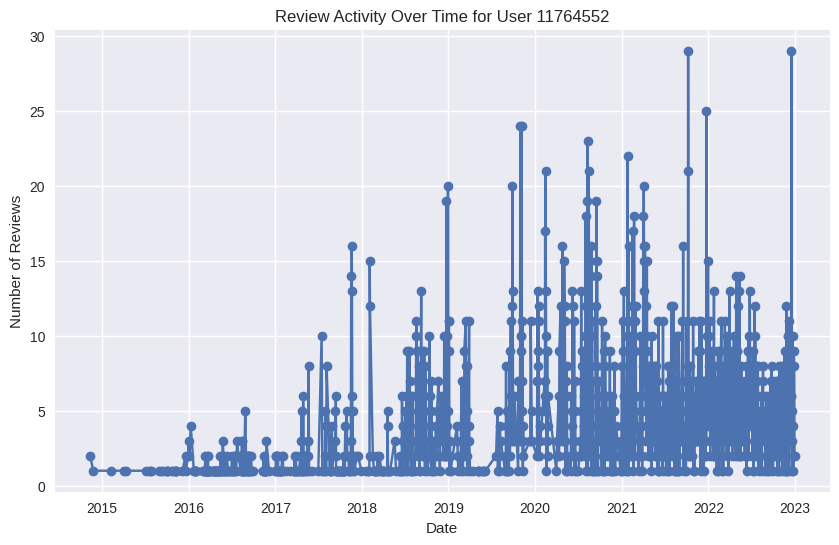

In [44]:
plot_user_reviews_over_time(recommendation_df, 11764552)


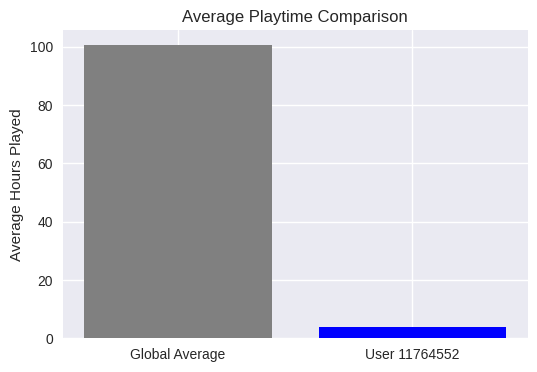

In [46]:
plot_user_vs_global_playtime(recommendation_df, 11764552)

In [52]:
# 1. Playtime Distribution for the Game
def plot_game_playtime_distribution(recommendation_df, app_id):
    game_reviews = recommendation_df[recommendation_df['app_id'] == app_id]

    plt.figure(figsize=(8, 5))
    plt.hist(game_reviews['hours'], bins=10, color='orange', alpha=0.7)
    plt.title(f"Playtime Distribution for Game {app_id}")
    plt.xlabel("Hours Played")
    plt.ylabel("Count")
    plt.show()

# 2. Game's Reviews Over Time
def plot_game_reviews_over_time(recommendation_df, app_id):
    game_reviews = recommendation_df[recommendation_df['app_id'] == app_id]
    game_reviews['date'] = pd.to_datetime(game_reviews['date'])
    reviews_by_date = game_reviews.groupby(game_reviews['date'].dt.date).size()

    plt.figure(figsize=(10, 6))
    reviews_by_date.plot(kind='line', marker='o', color='purple')
    plt.title(f"Review Activity Over Time for Game {app_id}")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.grid(True)
    plt.show()

# 3. User Ratings Distribution for the Game
def plot_game_user_rating_distribution(recommendation_df, app_id):
    game_reviews = recommendation_df[recommendation_df['app_id'] == app_id]

    plt.figure(figsize=(6, 4))
    plt.pie(
        game_reviews['is_recommended'].value_counts(),
        labels=['Recommended', 'Not Recommended'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['green', 'red']
    )
    plt.title(f"User Rating Distribution for Game {app_id}")
    plt.show()


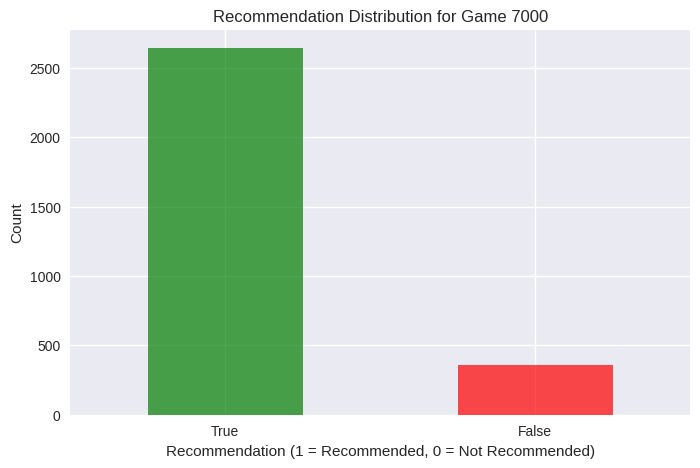

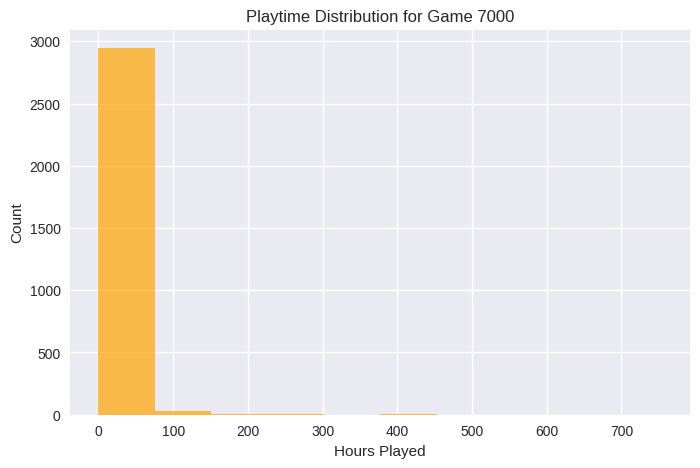

In [57]:
plot_game_playtime_distribution(recommendation_df, 7000)

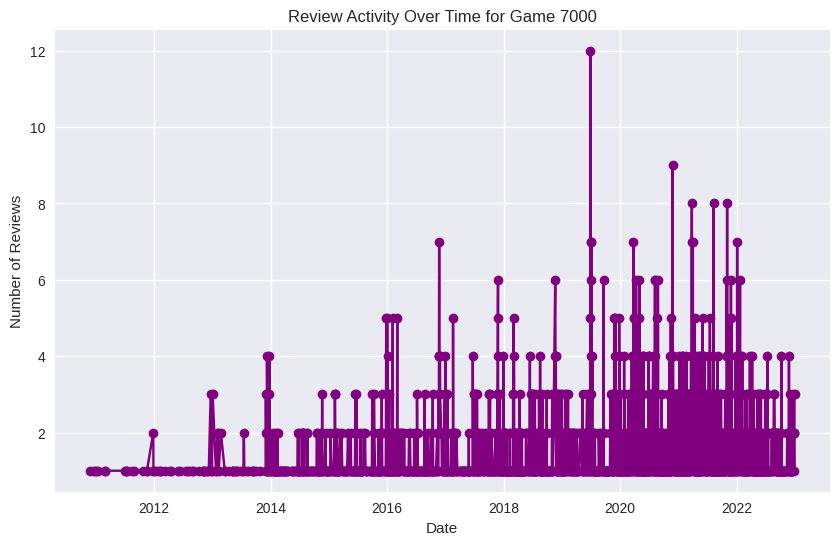

In [58]:
plot_game_reviews_over_time(recommendation_df, 7000)

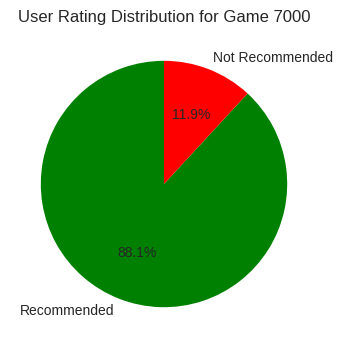

In [59]:
plot_game_user_rating_distribution(recommendation_df, 7000)